In [ ]:
!nvidia-smi


Sat Nov 16 06:01:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch
import torch.multiprocessing as mp
mp.set_start_method('fork', force=True)

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# DATA PREPROCESSING

In [ ]:
base_dir = "/content/drive/My Drive/Colab Notebooks/6401/covid_detection/"
train_dir = '/content/drive/My Drive/Colab Notebooks/6401/covid_detection/train/'
val_dir = '/content/drive/My Drive/Colab Notebooks/6401/covid_detection/val/'
test_dir = '/content/drive/My Drive/Colab Notebooks/6401/covid_detection/test/'

In [ ]:
def count_files_in_folder(folder_path):
    file_count = 0
    for root, dirs, files in os.walk(folder_path):
        file_count += len(files)
    return file_count

In [ ]:
total_files = count_files_in_folder(train_dir)
print(f"Total number of files: {total_files}")

Total number of files: 67863


In [ ]:
total_files = count_files_in_folder(test_dir)
print(f"Total number of files: {total_files}")

Total number of files: 8482


In [ ]:
total_files = count_files_in_folder(val_dir)
print(f"Total number of files: {total_files}")

Total number of files: 4695


In [ ]:
train_txt = "/content/drive/My Drive/Colab Notebooks/6401/covid_detection/train.txt"
val_txt = "/content/drive/My Drive/Colab Notebooks/6401/covid_detection/val.txt"
test_txt = "/content/drive/My Drive/Colab Notebooks/6401/covid_detection/test.txt"

In [ ]:
class CovidDataset(Dataset):
    def __init__(self, txt_file, base_dir, transform=None):
        """
        Args:
            txt_file (str): Path to the txt file (train/val/test).
            base_dir (str): Base directory where images are stored.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.base_dir = base_dir
        self.image_labels = []  # List to store (image_path, label) tuples
        self.transform = transform

        # Read the txt file and store image paths and labels
        with open(txt_file, 'r') as file:
            for line in file:
                items = line.strip().split()
                if len(items) < 3:
                    continue  # Skip invalid lines
                image_path = os.path.join(self.base_dir, items[1])
                label = 1 if items[2] == 'positive' else 0  # Convert labels to binary (1 for positive, 0 for negative)
                if os.path.exists(image_path):  # Check if the file exists
                    self.image_labels.append((image_path, label))
                else:
                    print(f"File not found, skipping: {image_path}")

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        image_path, label = self.image_labels[idx]
        # Open image
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
IMG_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])

In [ ]:
train_dataset = CovidDataset(txt_file=train_txt, base_dir=train_dir, transform=transform)
val_dataset = CovidDataset(txt_file=val_txt, base_dir=val_dir, transform=transform)
test_dataset = CovidDataset(txt_file=test_txt, base_dir=test_dir, transform=transform)


File not found, skipping: /content/drive/My Drive/Colab Notebooks/6401/covid_detection/train/1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg
File not found, skipping: /content/drive/My Drive/Colab Notebooks/6401/covid_detection/train/7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg
File not found, skipping: /content/drive/My Drive/Colab Notebooks/6401/covid_detection/val/CR.1.2.840.113564.1722810170.20200318082923328940.1003000225002.png
File not found, skipping: /content/drive/My Drive/Colab Notebooks/6401/covid_detection/val/CR.1.2.840.113564.1722810170.20200320011259312440.1003000225002.png
File not found, skipping: /content/drive/My Drive/Colab Notebooks/6401/covid_detection/val/sub-S03044_ses-E06138_run-1_bp-chest_vp-ap_cr-corrected.png
File not found, skipping: /content/drive/My Drive/Colab Notebooks/6401/covid_detection/val/sub-S03044_ses-E07712_run-1_bp-chest_vp-ap_cr-corrected.png
File not found, skipping: /content/drive/My Drive/Colab Notebooks/6401/covid_detection/val/sub-S03044_ses-E067

In [ ]:
BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)


In [ ]:
def move_to_device(data_loader, device):
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        yield images, labels


In [ ]:
print(f"Train dataset size: {len(train_dataset)} images")
print(f"Validation dataset size: {len(val_dataset)} images")
print(f"Test dataset size: {len(test_dataset)} images")

Train dataset size: 67861 images
Validation dataset size: 4695 images
Test dataset size: 8482 images


In [ ]:
for images, labels in move_to_device(train_loader, device):
    print(f"Batch image size: {images.size()}")
    print(f"Batch labels: {labels}")
    break

Batch image size: torch.Size([32, 3, 224, 224])
Batch labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')


# MODEL TRAINING

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Subset
import random
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Save checkpoint function
def save_checkpoint(model, optimizer, epoch, best_val_loss, checkpoint_dir):
    checkpoint = {
        'epoch': epoch + 1,  # Save next epoch to resume correctly
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'best_val_loss': best_val_loss
    }
    torch.save(checkpoint, os.path.join(checkpoint_dir, "model_checkpoint.pt"))
    print(f"Checkpoint saved at epoch {epoch + 1}.")

In [ ]:
def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    epoch = checkpoint['epoch']
    best_val_loss = checkpoint['best_val_loss']
    print(f"Checkpoint loaded. Resuming from epoch {epoch}.")
    return model, optimizer, epoch, best_val_loss

In [ ]:
checkpoint_dir = "/content/drive/My Drive/Colab Notebooks/6401/covid_detection/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
# Load the pretrained ResNet-18 model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)  # Modify for binary classification
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 212MB/s]


In [ ]:
# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Mixed precision training setup
scaler = GradScaler()

<ipython-input-15-bb9d2625c7b0>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
# Checkpoint path
checkpoint_path = os.path.join(checkpoint_dir, "model_checkpoint.pt")

# Check if checkpoint exists and load it
if os.path.exists(checkpoint_path):
    model, optimizer, start_epoch, best_val_loss = load_checkpoint(checkpoint_path, model, optimizer)
else:
    print("No checkpoint found. Starting from scratch.")
    start_epoch = 0  # Start from scratch
    best_val_loss = float('inf')


<ipython-input-15-b2d86de9d0ff>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Checkpoint loaded. Resuming from epoch 4.


In [ ]:
subset_fraction = 0.2  # Use 20% of the training data

# Generate random indices for subsampling
subset_size = int(len(train_dataset) * subset_fraction)
indices = np.random.choice(len(train_dataset), subset_size, replace=False)

# Create a subset of the training dataset
train_subset = Subset(train_dataset, indices)

In [ ]:
BATCH_SIZE = 64  # Increase if GPU memory allows
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0)


In [ ]:
EPOCHS = 10
train_losses = []
val_losses = []
patience = 3  # Stop after 3 epochs with no improvement
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(start_epoch, EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")

    # Training phase
    model.train()
    running_train_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad()

        # Forward pass
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

        # Backward pass and optimization
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_train_loss += loss.item()

        if (batch_idx + 1) % 25 == 0:  # Save checkpoint every 100 batches
            save_checkpoint(model, optimizer, epoch, best_val_loss, checkpoint_dir)
            print(f"Checkpoint saved mid-epoch at batch {batch_idx + 1}.")

    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Training Loss: {train_loss:.4f}")

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device)
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            predictions = torch.sigmoid(outputs) > 0.5
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    val_loss = running_val_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_checkpoint(model, optimizer, epoch, best_val_loss, checkpoint_dir)
        patience_counter = 0  # Reset counter
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epoch(s).")
        if patience_counter >= patience:
            print("Early stopping triggered. Stopping training.")
            break


Epoch 1/10
Checkpoint saved at epoch 1.
Checkpoint saved mid-epoch at batch 25.
Checkpoint saved at epoch 1.
Checkpoint saved mid-epoch at batch 50.
Checkpoint saved at epoch 1.
Checkpoint saved mid-epoch at batch 75.
Checkpoint saved at epoch 1.
Checkpoint saved mid-epoch at batch 100.
Checkpoint saved at epoch 1.
Checkpoint saved mid-epoch at batch 125.
Checkpoint saved at epoch 1.
Checkpoint saved mid-epoch at batch 150.
Checkpoint saved at epoch 1.
Checkpoint saved mid-epoch at batch 175.
Checkpoint saved at epoch 1.
Checkpoint saved mid-epoch at batch 200.
Training Loss: 0.0873
Validation Loss: 0.1235, Validation Accuracy: 95.31%
Checkpoint saved at epoch 1.

Epoch 2/10
Checkpoint saved at epoch 2.
Checkpoint saved mid-epoch at batch 25.
Checkpoint saved at epoch 2.
Checkpoint saved mid-epoch at batch 50.
Checkpoint saved at epoch 2.
Checkpoint saved mid-epoch at batch 75.
Checkpoint saved at epoch 2.
Checkpoint saved mid-epoch at batch 100.
Checkpoint saved at epoch 2.
Checkpoin

In [ ]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

model_save_path = os.path.join(checkpoint_dir, "final_model.pth")
save_model(model, model_save_path)

Model saved to /content/drive/My Drive/Colab Notebooks/6401/covid_detection/checkpoints/final_model.pth


In [ ]:
def load_final_model(model_path, device):
    # Define the same model architecture used during training
    model = models.resnet18()
    model.fc = nn.Linear(model.fc.in_features, 1)  # Adjust for binary classification

    # Load the saved model weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Loaded final model from {model_path}")
    return model

In [ ]:
def test_final_model(model_path, test_loader, device):
    # Load the model
    model = load_final_model(model_path, device)
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    # Define loss function
    criterion = nn.BCEWithLogitsLoss()

    running_test_loss = 0.0
    correct = 0
    total = 0

    # Testing loop
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.float().to(device)

            # Forward pass
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            # Predictions and accuracy
            predictions = torch.sigmoid(outputs) > 0.5
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    test_loss = running_test_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


In [ ]:
model_path = "/content/drive/My Drive/Colab Notebooks/6401/covid_detection/checkpoints/final_model.pth"  # Replace with your final model file path
test_final_model(model_path, test_loader, device)

Test Loss: 3.6914, Test Accuracy: 62.51%


# USE MODEL

In [ ]:
def load_saved_model(model_path, device):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 1)  # Adjust for binary classification
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Loaded model from {model_path}")
    return model

In [ ]:
def display_images_with_labels(images, actual_labels, predicted_labels=None):
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(2, 5, i + 1)
        image = transforms.ToPILImage()(images[i])
        plt.imshow(image, cmap="gray")
        title = f"Actual: {actual_labels[i].item()}"
        if predicted_labels is not None:
            title += f"\nPredicted: {predicted_labels[i].item()}"
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
def test_subset_with_display(model_path, test_dataset, device, num_images=50):
    # Load the saved model
    model = load_saved_model(model_path, device)

    # Randomly select 10 images
    indices = random.sample(range(len(test_dataset)), num_images)
    test_subset = Subset(test_dataset, indices)
    test_loader_subset = DataLoader(test_subset, batch_size=num_images, shuffle=False)

    # Evaluate the selected images
    with torch.no_grad():
        for images, labels in test_loader_subset:

            # Move data to device
            images, labels = images.to(device), labels.to(device)

            # Predict using the model
            outputs = model(images).squeeze()
            probabilities = torch.sigmoid(outputs)
            predicted_labels = (probabilities > 0.5).long()

            # Display the images with predictions
            display_images_with_labels(images.cpu(), actual_labels=labels.cpu(), predicted_labels=predicted_labels.cpu())


<ipython-input-19-9102b7b97e24>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Loaded model from /content/drive/My Drive/Colab Notebooks/6401/covid_detection/checkpoints/final_model.pth


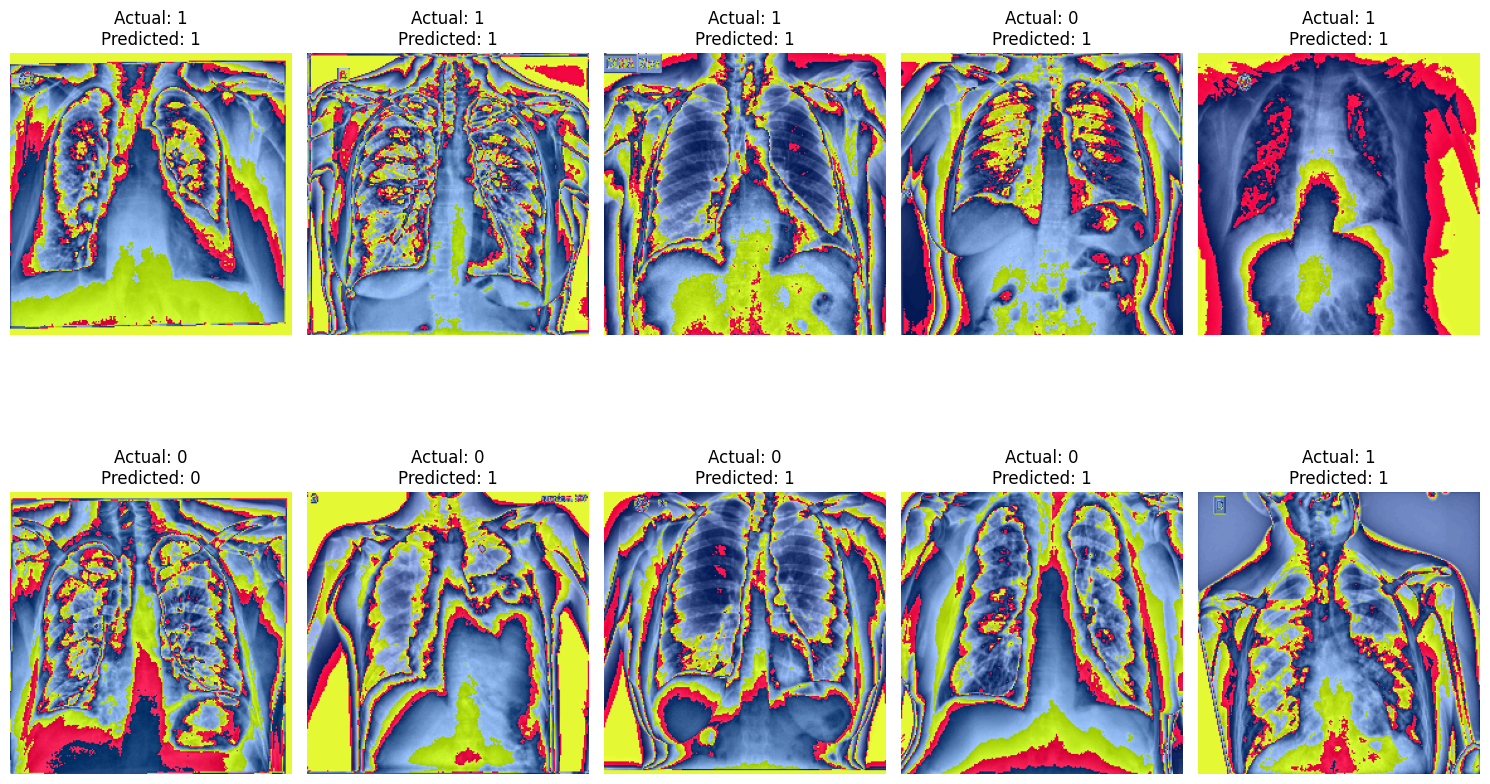

In [ ]:
model_path = "/content/drive/My Drive/Colab Notebooks/6401/covid_detection/checkpoints/final_model.pth"

test_subset_with_display(model_path, test_dataset, device, num_images=10)